# Flowers Recognition (Deep Learning)

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
pip install tensorflow  --quiet

In [5]:
import jovian

In [6]:

# Execute this to save new versions of the notebook
jovian.commit(project="flowers-recognition-deep-learning")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning


'https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning'

## Preprocessing Steps

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training

In [7]:
import numpy as np
import os
import shutil
import opendatasets as od
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [8]:
print(tf.__version__)

2.9.2


In [9]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [10]:
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [11]:
data_dir = './flowers-recognition/flowers'

In [12]:
os.listdir(data_dir)

['rose', 'tulip', 'daisy', 'dandelion', 'sunflower']

In [13]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

rose : 784
tulip : 980
daisy : 764
dandelion : 1050
sunflower : 733


In [14]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning


'https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning'

In [15]:
num_skipped = 0

for folder_name in ('tulip', 'rose', 'sunflower', 'dandelion', 'daisy'):
  folder_path = os.path.join('flowers-recognition/flowers', folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      #delete corrupted image
      os.remove(fpath)

print("Deleated %d images" % num_skipped)

Deleated 0 images


## Import the dataset in Tensorflow Keras

In [16]:
image_size = (180 , 180)
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers-recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size = batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers-recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size = batch_size
)

Found 4311 files belonging to 5 classes.
Using 3449 files for training.
Found 4311 files belonging to 5 classes.
Using 862 files for validation.


### Visualize the data

In [17]:
import matplotlib.pyplot as plt

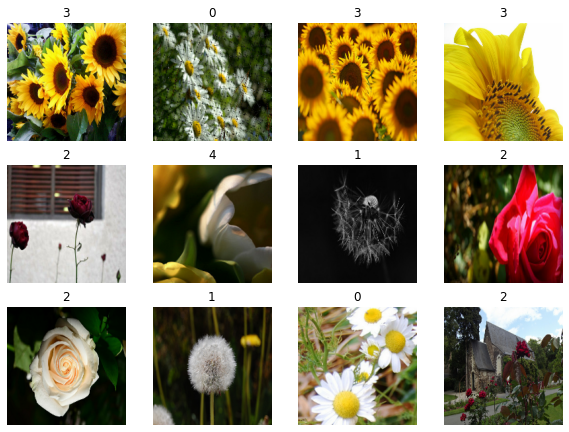

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning


'https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning'

## Using Image data Augmentation

When we don't have large image datset, we introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This help to expose the model to different aspects of the training data while slowing down overfitting.

In [20]:
data_augumented = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

Let's visulalize what the augmented samples look like by applying data_augumented repeatedely to the first image of the dataset:

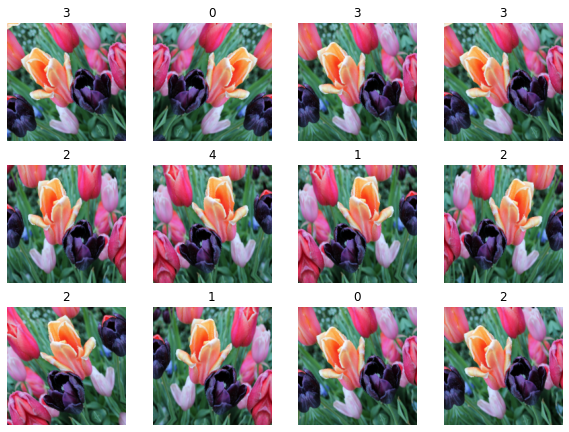

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(12):
        augmented_image = data_augumented(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [22]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning


'https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning'

## Standardizing the data

Our images are in a standard size (180*180), as they are being yielded as contiguous float32 batches by our datset. But their RGB channel values are still in the (0 , 255) range. This is not for Neural network. In general, we need to make input values small. we will standardize our input values to be (0,1) by usinf Rescaling layes at the start of model

In [23]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configure the dataset for performance - overlaps data preprocessing and model execution while training.

In [24]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Building a Model

In [25]:
class_names = ['daisy', 'dandelion', 'rose',  'sunflower', 'tulip']

In [26]:
num_classes=len(class_names)
num_classes

5

In [27]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augumented(x, training=True), y))

tf.keras.layers.Conv2D - 2D convolution layer (e.g. spatial convolution over images). Inherits From: Layer, Module

tf.keras.layers.MaxPool2D - Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

tf.keras.layers.Dense - Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense.

In [28]:
model= Sequential([
    data_augumented,
    tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=5)
])

In [29]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])

In [30]:
num_epochs = 10
model.fit(x=train_ds, epochs = num_epochs, validation_data = val_ds,verbose = 2)

Epoch 1/10
69/69 - 16s - loss: 1.2986 - accuracy: 0.4567 - val_loss: 1.0947 - val_accuracy: 0.5731 - 16s/epoch - 239ms/step
Epoch 2/10
69/69 - 8s - loss: 1.0581 - accuracy: 0.5810 - val_loss: 0.9838 - val_accuracy: 0.6090 - 8s/epoch - 122ms/step
Epoch 3/10
69/69 - 10s - loss: 0.9373 - accuracy: 0.6382 - val_loss: 0.9745 - val_accuracy: 0.6160 - 10s/epoch - 139ms/step
Epoch 4/10
69/69 - 8s - loss: 0.8545 - accuracy: 0.6669 - val_loss: 0.9398 - val_accuracy: 0.6323 - 8s/epoch - 122ms/step
Epoch 5/10
69/69 - 8s - loss: 0.7958 - accuracy: 0.6935 - val_loss: 0.8800 - val_accuracy: 0.6833 - 8s/epoch - 120ms/step
Epoch 6/10
69/69 - 8s - loss: 0.7430 - accuracy: 0.7104 - val_loss: 0.8608 - val_accuracy: 0.6810 - 8s/epoch - 121ms/step
Epoch 7/10
69/69 - 10s - loss: 0.7211 - accuracy: 0.7243 - val_loss: 0.8185 - val_accuracy: 0.7007 - 10s/epoch - 142ms/step
Epoch 8/10
69/69 - 9s - loss: 0.6761 - accuracy: 0.7417 - val_loss: 0.8101 - val_accuracy: 0.6937 - 9s/epoch - 130ms/step
Epoch 9/10
69/69 -

### Predict the model

Predict the model and show the images whether true or false

1/1 [==============================] - 0s 18ms/step


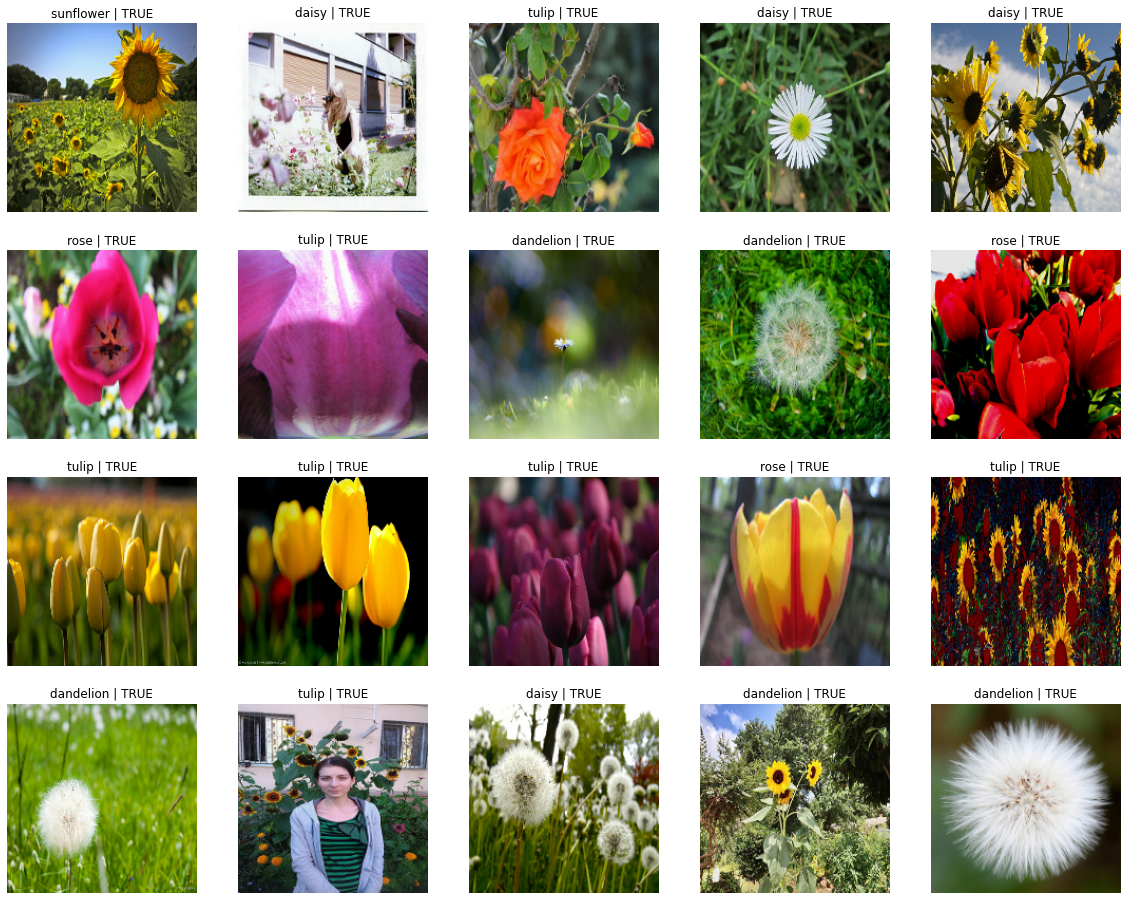

In [31]:
plt.figure(figsize=(20, 16))
class_names = ['daisy', 'dandelion', 'rose',  'sunflower', 'tulip']
result = ' | False'
for images, labels in val_ds.take(1):
    for i in range(20):
        
        ax = plt.subplot(4, 5, i + 1)
        
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

In [32]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning


'https://jovian.ai/mohitcnf95/flowers-recognition-deep-learning'